# Implementation of explainable AI for classification using probabilistic logic inference  

This code is based on the paper **Explainable AI for Classification using Probabilistic Logic Inference** by *Fan et al* that can be found [here](https://arxiv.org/abs/2005.02074)

This program utilizes a heart disease dataset from [kaggle](https://www.kaggle.com/ronitf/heart-disease-uci). All acknowledgements of the dataset can be found on the dataset home page. 

This is a binary classification problem, in which we use about 10 features to predict the presence of heart disease in a patient. We will first run a probabilistic model to classify our problem. For the case of simplicity, a Naive Bayes Classifier is used from the [scikit-learn](https://scikit-learn.org/stable/modules/naive_bayes.html) toolkit. Following this, all algorithms from the above-mentioned paper are implemented to **predict and explain** our heart disease problem. For the sake of simplicity, all features are categorized as binary variables. This results in a loss of energy, but would account for the difference in F1 score and accuracy between this model and a deterministic one (explained below)

Two deterministic models are trained (in a seperate file i.e *heart_deterministic.ipynb*) to serve as a baseline. Random forrests (scikit-learn) and neural networks (keras). For these models, the features are only standardized.

## Imports  

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain, combinations

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# Gurobi Linear Solver
import gurobipy as gp
from gurobipy import GRB
from gurobipy import LinExpr, quicksum

## Data cleaning and pre-processing

Data is first loaded from a csv file. The following is a description of the features (noted from the dataset homepage):

1. **age:** age
2. **sex**: sex (1 = male, 0 = female)
3. **cp:** chest pain type (4 values)
4. **trestbps:** resting blood pressure
5. **chol:** serum cholestoral in mg/dl
6. **fbs:** fasting blood sugar > 120 mg/dl
7. **restecg:** resting electrocardiographic results (values 0,1,2)
8. **thalach:** maximum heart rate achieved
9. **exang:** exercise induced angina
10. **oldpeak:** oldpeak = ST depression induced by exercise relative to rest
11. **slope:** the slope of the peak exercise ST segment
12. **ca:** number of major vessels (0-3) colored by flourosopy
13. **thal:** thal: (4 values)

Of these features, *slope*, *restecg*, and *ca* were removed for two major reasons:
1. They did not fit nicely into a binary categorization  
2. To reduce computational complexity  

The column *target* is the label. 1 denotes presence of heart disease and viceversa. 

After being loaded, the data is shuffled, and headers extracted for later use. Run the block of code below to see raw data loaded.

In [2]:
df = pd.read_csv(open("heart.csv"))
df = df.drop(["slope", "restecg", "ca"], axis = 1)
headers = df.columns.tolist()
df = df.sample(frac = 1)
df

,age,sex,cp,trestbps,chol,fbs,thalach,exang,oldpeak,thal,target
164,38,1,2,138,175,0,173,0,0.0,2,1
247,66,1,1,160,246,0,120,1,0.0,1,0
125,34,0,1,118,210,0,192,0,0.7,2,1
39,65,0,2,160,360,0,151,0,0.8,2,1
71,51,1,2,94,227,0,154,1,0.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...
54,63,0,2,135,252,0,172,0,0.0,2,1
150,66,1,0,160,228,0,138,0,2.3,1,1
129,74,0,1,120,269,0,121,1,0.2,2,1
285,46,1,0,140,311,0,120,1,1.8,3,0


The only preprocessing step involved is binary categorization. Since the features *sex*, *fbs*, and *exang* are already binary, they are omitted from this step. Run the block of code below to see the processed dataframe.

In [3]:
# preprocessing

# converting all continuos data to categorical - using percentiles
columns = ("age", "cp", "trestbps", "chol", "thalach", "oldpeak", "thal")

for col in columns:
    df[col], tiles = pd.qcut(df[col], 2, labels = False, retbins = True, duplicates = "drop")
    print(col, " categories with bin edges: ", tiles)
df

age  categories with bin edges:  [29. 55. 77.]
cp  categories with bin edges:  [0. 1. 3.]
trestbps  categories with bin edges:  [ 94. 130. 200.]
chol  categories with bin edges:  [126. 240. 564.]
thalach  categories with bin edges:  [ 71. 153. 202.]
oldpeak  categories with bin edges:  [0.  0.8 6.2]
thal  categories with bin edges:  [0. 2. 3.]


,age,sex,cp,trestbps,chol,fbs,thalach,exang,oldpeak,thal,target
164,0,1,1,1,0,0,1,0,0,0,1
247,1,1,0,1,1,0,0,1,0,0,0
125,0,0,0,0,0,0,1,0,0,0,1
39,1,0,1,1,1,0,0,0,0,0,1
71,0,1,1,0,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
54,1,0,1,1,1,0,1,0,0,0,1
150,1,1,0,1,0,0,0,0,1,0,1
129,1,0,0,0,1,0,0,1,0,0,1
285,0,1,0,1,1,0,0,1,1,1,0


## Naive Bayes Classifier  

Next step is to implement a simple Naive Bayes Classifier. The train-test split is kept at 80-20 (this split is not important, as this classifier is non-parametric). Implementing a Naive Bayes classifier is simple enough due to *scikit-learn*. Run the code below to find the *accuracy* and *f1-score* for classification on this dataset using the probabilistic model: Naive-Bayes.

In [4]:
# train-test split
split = 0.8
num_train = round(len(df) * split)

train_data = np.array(df.iloc[:num_train, :-1])
train_labels = np.array(df.iloc[:num_train, -1])

test_data = np.array(df.iloc[num_train:, :-1])
true_labels = np.array(df.iloc[num_train:, -1])

pred_labels = GaussianNB().fit(train_data, train_labels).predict(test_data)

print("Naive Bayes Model predictions: ")
print("Accuracy: ", accuracy_score(true_labels, pred_labels))
print("F1 Score: ", f1_score(true_labels, pred_labels))

Naive Bayes Model predictions: 
Accuracy:  0.8524590163934426
F1 Score:  0.8695652173913043


## Algorithm proposed by Fan et al

Next is the implementation of the algorithm proposed in the paper mentioned above. In addition to classifying a dataset, this algorithm also suggests explanation for the result. The model is implemented in the following steps:  
1. Constructing Knowledge Base directly (Algorithm 3)  
2. Constructing Knowledge Base relevant to query (Algorithm 5)  
3. Solving a single Query (Algorithm 4)  
4. Explaining a single Query (Algorithm 6)

These step numbers would be used in the explanations that follow.

### Step 1

This detail a procedural construction of the knowledge base (hereafter referred to as KB). The function ```powerset``` returns a set of all possible subsets of a query. The ```constructKb``` function utilizes this on all queries, and counts the results to allow for a step-by-step construction of the KB.


In [5]:
def powerset(iterable):
    '''
    Returns a powerset from the provided iterable.
    
        Parameters:
            iterable (iter): the initial set
        
        Returns:
            k (list): a list of all subsets with strings in each subset joined to form a clause
    '''
    it = list(iterable)
    k = chain.from_iterable(combinations(it, a) for a in range(1, len(it)+1))
    k = [list(j) for j in k]
    for j in k:
        j = j.sort(key = lambda x: x.split("_")[0])
    k = ["-".join(a) for a in k]
    return k

In [6]:
def constructKb(df):
    '''
    Constructs Kb from a pandas dataframe.
    
        Parameters:
            df (pandas.Dataframe): the dataset
            
        Returns:
            Kb (dict): a dictionary containing clauses and respective probabilities
    '''
    
    # converting data to a numpy array
    data = np.array(df)
    
    counts = {}
    Kb = {}
    
    for row in data:
        feaVals = set([headers[i] + "_" + str(row[i]) for i in range(len(headers) - 1) if row[i] != -1])
        label = int(row[-1])
        k = powerset(feaVals)
        for key in k:
            if key in counts:
                counts[key][0] += 1
                counts[key][1] += label
            else:
                counts[key] = [1, label]
    
    # counting
    for key in counts:
        r = counts[key][1]/counts[key][0]
        Kb["POS-" + key] = r
    return Kb

Run the following block to construct KB. This also prints the length of the knowledge base, alongside a random sample of what a clause looks like. The "OR NEGATION" symbol in literature is replaced by a simple "-".

In [7]:
Kb = constructKb(df.iloc[:num_train, :])
print("Number of clauses in the Knowledge Base: ", len(Kb))
print("Example clause-probability pair: ", list(Kb.items())[random.randint(0, len(Kb) - 1)])

Number of clauses in the Knowledge Base:  38599
Example clause-probability pair:  ('POS-age_0-chol_0-cp_0-oldpeak_1-sex_1-trestbps_1', 0.25)


### Step 2

The function ```constructRelevantKb``` weeds out irrelevant clauses to form a query-relevant knowledge base, that has far less items than the universal Kb. This significantly helps reduce the time to linearly *solve* a query.

In [8]:
def constructRelevantKb(row, Kb):
    '''
    Reduces Kb to a relevant Kb dependent on the specified query
    
        Parameters:
            row (list): a single query. Absent values to be replaced by -1
            Kb (dict): the universal knowledge base
            
        Returns:
            rel_Kb (dict): a query-relevant knowledge base.
    '''
    rel_Kb = {}
    feaVals = set([headers[i] + "_" + str(row[i]) for i in range(len(headers) - 1) if row[i] != -1])
    k = powerset(feaVals)
    clauses = list(Kb.keys())
    for key in k:
        if "POS-" + key in clauses:
            rel_Kb["POS-" + key] = Kb["POS-" + key]
    return rel_Kb

Run the following block to construct an example relevant knowledge base. See that the number of clauses in this knowledge base is far less than that of the universal Kb.

In [9]:
relKb = constructRelevantKb(np.array(df)[random.randint(0, 300)], Kb)
print("Number of clauses in relevant Kb: ", len(relKb))
print("Number of clauses in universal Kb: ", len(Kb))

Number of clauses in relevant Kb:  1023
Number of clauses in universal Kb:  38599


### Step 3

The following function `solveOneQuery` implements the linear system proposed by *Fan et al* using the [Gurobi](https://www.gurobi.com/) linear solver. Using this solver at this scale requires a lisence. A free trial can be acquired by following the steps mentioned [here](https://www.gurobi.com/academia/academic-program-and-licenses/). Please note that without the lisence, the script may not work; so it is imperative, that **the user correctly installs the optimizer and the lisence in the correct path according to their OS** (steps provided in the link). Further information may be found in the README.md file associated with the repository containing this file.

In [10]:
def solveOneQuery(query):
    '''
    Function for linear programming. Utilizes the Gurobi solver to solve the system proposed by Fan et al
    
        Parameters:
            query (list): a single row of data
            
        Returns:
            w_POS (float): a probability value.
    '''
    
    
    # dicts to house Gurobi variables
    clauseVars = {}
    dummyClauseVars = {}
    headerVars = {}
    
    # constructing relevant Knowledge base using "Algorithm 5"
    relKb = constructRelevantKb(query, Kb)
    
    # initializing model
    m = gp.Model("fan_et_al")
    m.setParam("OutputFlag", 0)
    
    # clause probabilities
    for i in relKb:
        # initializing variables for all clause probabilities
        clauseVars[i] = m.addVar(vtype=GRB.CONTINUOUS, name = i)
        
        # dummy variables used to replace abs() in linear solver
        dummyClauseVars[i] = m.addVar(vtype=GRB.CONTINUOUS, name = "dummy_"+i)
        m.addConstr(dummyClauseVars[i] >= clauseVars[i] - relKb[i])
        m.addConstr(dummyClauseVars[i] >= relKb[i] - clauseVars[i])
    
    # literal probabilities
    for i in headers[:-1]:
        headerVars[i + "_0"] = m.addVar(vtype=GRB.CONTINUOUS, name = i + "_0")
        headerVars[i + "_1"] = m.addVar(vtype=GRB.CONTINUOUS, name = i + "_1")
        
        # defining bounds as in Definition 4 (5)
        m.addConstr(headerVars[i + "_1"] + headerVars[i + "_0"] == 1)

    headerVars["POS"] = m.addVar(vtype=GRB.CONTINUOUS, name = "POS")

    for i in headerVars:
        # defining bounds as in Definition 4 (6)
        m.addConstr(headerVars[i] >= 0)
        m.addConstr(headerVars[i] <= 1) 
    
    for i in relKb:
        j = i.split("-")
        j = [a.replace("_0", "_1") if "_0" in a else a.replace("_1", "_0") for a in j]
        j = [headerVars[a] for a in j]
        
        # defining constraints for the Boole's inequality
        m.addConstr(clauseVars[i] <= quicksum(j))
        
        # monotonicity
        for cl in j:
            m.addConstr(clauseVars[i] >= cl)

    # query specific constraints according to "Algorithm 4"
    for i in range(len(headers) - 1):
        if query[i] == 1:
            m.addConstr(headerVars[headers[i]+"_1"] == 1)
            m.addConstr(headerVars[headers[i]+"_0"] == 0)
        elif query[i] == 0:
            m.addConstr(headerVars[headers[i]+"_1"] == 0)
            m.addConstr(headerVars[headers[i]+"_0"] == 1)

    # setting objective
    expr = LinExpr()
    for a in relKb:
        expr.addTerms(1.0, dummyClauseVars[a])
    m.setObjective(expr, GRB.MINIMIZE)

    m.optimize()
    w_POS = headerVars["POS"].x
    
    return w_POS

An example query is solved. Run the code below.

In [11]:
index = random.randint(0, 300)
print("Sample Query: ")
display(df.iloc[index:index + 1, :])

w_POS = solveOneQuery(np.array(df)[index])
print("w_POS found to be: ", w_POS)

if (w_POS < 0.5):
    print("Since probability < 0.5, the query will be classified as: ", 0, " (negative)")
else:
    print("Since probability >= 0.5, the query will be classified as: ", 1, " (positive)")
    
print()
print("True label: ", np.array(df)[index][-1])

Sample Query: 


,age,sex,cp,trestbps,chol,fbs,thalach,exang,oldpeak,thal,target
220,1,0,0,1,1,0,1,0,1,1,0


Academic license - for non-commercial use only - expires 2021-06-02
Using license file /opt/gurobi911/gurobi.lic
w_POS found to be:  0.2631578947368421
Since probability < 0.5, the query will be classified as:  0  (negative)

True label:  0


The entire dataset will be passed through the linear solver, following which the accuracy and f1-score would be determined. Since this algorithm has the advantage of being non-parametric, a train-test split is of secondary importance. **The following process may take a few minutes (depending upon your hardware)**.

In [12]:
res = []
l = 0
print("Starting Linear Solver....")
for query in test_data:
    l += 1
    if l % 50 == 0:
        print(l, " rows solved")
    res.append(1 if solveOneQuery(query) >= 0.5 else 0)
print("Solved.")

Starting Linear Solver....
50  rows solved
Solved.


In [13]:
print("Accuracy: ", accuracy_score(true_labels, res))
print("F1 Score: ", f1_score(true_labels, res))

Accuracy:  0.8032786885245902
F1 Score:  0.8421052631578948


### Step 4

The algorithm shows decent accuracy and f1-score. Now, we move on to the explanation part, that is the crux of this algorithm. The function `explainQuery` lists the features (number dependent on argument provided to the function) that explain the decision. Running the following three blocks of code will show an example query and the features that explain its prediction.

In [14]:
def explainQuery(q, k = 1):
    '''
    Lists which features are responsible for the respective prediction of a specific query
    
        Parameters:
            q (list): A query to be explained
            k (int): The number of required features as explanation. Defaults to 1.
                    Constrained to the length of features.
        
        Returns:
            count (list): A list of features that explain prediction
            class_ (float): The value of w_POS
    '''
    probs = []
    
    # restrict k. Relies on user intelligence to not provide any other variable type than 'int'
    k = 1 if k < 1 else k
    k = len(headers) - 1 if k > len(headers) - 1 else k
    
    # forms a combination of k elements from query
    comb = combinations(headers[:-1], k)
    
    # prediction
    class_ = solveOneQuery(q)
    
    for a in comb:
        # for every entry missing, replace it by -1
        query = prepareQuery(a, q)
        probs.append({
            "explanation": a,
            "w_POS": solveOneQuery(query) 
        })
    
    # if prediction positive, find the clause that maximizes w_POS
    if class_ >= 0.5:
        probs = sorted(probs, key = lambda x: x["w_POS"], reverse = True)
        say = "positive"
    # if prediction positive, find the clause that minimizes w_POS
    else:
        probs = sorted(probs, key = lambda x: x["w_POS"])
        say = "negative"

    
    # cater for multiple clauses with same w_POS
    opt = probs[0]["w_POS"]
    probs = [prob for prob in probs if prob["w_POS"] == opt]

    count = {}
    for prob in probs:
        for key in prob["explanation"]:
            if key in count:
                count[key] += 1
            else:
                count[key] = 1

    count = [{a: count[a]} for a in list(count.keys())]
    count = sorted(count, key = lambda x: list(x.values())[0], reverse = True)[:k]
    count = [list(a.keys())[0] for a in count]
    
    print(", ".join(count), "is/are primarily responsible for the ", say, " result of this query.")
    return count, class_

In [15]:
def prepareQuery(include, query):
    '''
    Replaces every feature not present in include but in query with -1
    
        Parameters:
            include (list): A list of features to include in query
            query (list): The universal query
            
        Returns:
            q (list): A prepared query for explanation
    '''
    q = []
    for i in headers[:-1]:
        if i in include:
            q.append(query[headers.index(i)])
        else:
            q.append(-1)
    return q

In [16]:
index = random.randint(0, 300)
display(df.iloc[index:index + 1, :])
res = explainQuery(np.array(df)[index], k = 3)

,age,sex,cp,trestbps,chol,fbs,thalach,exang,oldpeak,thal,target
41,0,1,0,0,1,0,1,0,0,0,1


age, thalach, thal is/are primarily responsible for the  positive  result of this query.


### Feature Importance

The following code runs the explanation function on all queries to decide the importance of each feature to the result. This is done for posivite and negative heart disease target, and also for the complete dataset (akin to feature importance, with which it will also be compared to).

In [17]:
onlyPos = []
onlyNeg = []
allData = []
for q in np.array(df):
    exp = explainQuery(q, k = 2)
    feature = exp[0]
    if exp[1] >= 0.5:
        onlyPos += [f + " = " + str(q[headers.index(f)]) for f in feature]
        allData += [f for f in feature]
    else:
        onlyNeg += [f + " = " + str(q[headers.index(f)]) for f in feature]
        allData += [f for f in feature]

oldpeak, age is/are primarily responsible for the  positive  result of this query.
exang, age is/are primarily responsible for the  negative  result of this query.
oldpeak, age is/are primarily responsible for the  positive  result of this query.
oldpeak, sex is/are primarily responsible for the  positive  result of this query.
oldpeak, age is/are primarily responsible for the  positive  result of this query.
oldpeak, age is/are primarily responsible for the  positive  result of this query.
oldpeak, trestbps is/are primarily responsible for the  positive  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
thal, cp is/are primarily responsible for the  negative  result of this query.
oldpeak, age is/are primarily responsible for the  positive  result of this query.
cp, age is/are primarily responsible for the  positive  result of this query.
oldpeak, age is/are primarily responsible for the  positive  result of this query.
oldpeak, age 

thal, sex is/are primarily responsible for the  negative  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
cp, fbs is/are primarily responsible for the  positive  result of this query.
oldpeak, trestbps is/are primarily responsible for the  positive  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
thal, cp is/are primarily responsible for the  negative  result of this query.
oldpeak, age is/are primarily responsible for the  positive  result of this query.
oldpeak, cp is/are primarily responsible for the  positive  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
exang, cp is/are primarily responsible for the  negative  result of this query.
sex, trestbps is/are primarily responsible for the  positive  result of this query.
oldpeak, sex is/are primarily responsible for the  positive  result of this query.
thal, age is/are primar

oldpeak, sex is/are primarily responsible for the  positive  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
oldpeak, sex is/are primarily responsible for the  positive  result of this query.
cp, age is/are primarily responsible for the  positive  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
exang, age is/are primarily responsible for the  negative  result of this query.
thal, age is/are primarily responsible for the  negative  result of this query.
sex, fbs is/are primarily responsible for the  positive  result of this query.
oldpeak, age is/are primarily responsible for the  positive  result of this query.
cp, chol is/are primarily responsible for the  positive  result of this query.
thal, cp is/are primarily responsible for the  negative  result of this query.
exang, age is/are primarily respons

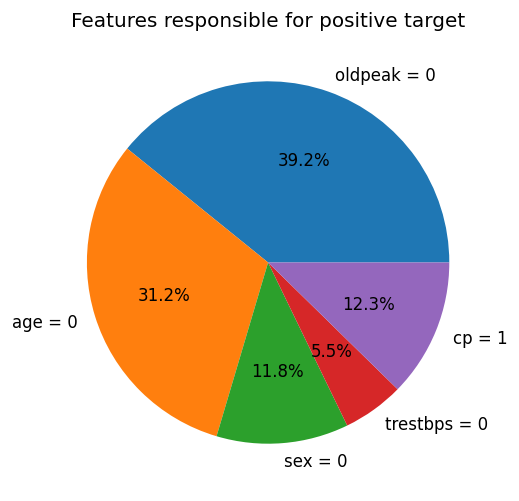

In [18]:
counter = Counter(onlyPos)

# limiting features to top 5 only 
top = 5
features_pos = list(counter.keys())[:top]
values_pos = np.array(list(counter.values()))[:top]

plt.figure(figsize=(5, 5), dpi = 120)

plt.title("Features responsible for positive target")
plt.pie(values_pos, labels = features_pos, autopct='%.1f%%')
plt.show()

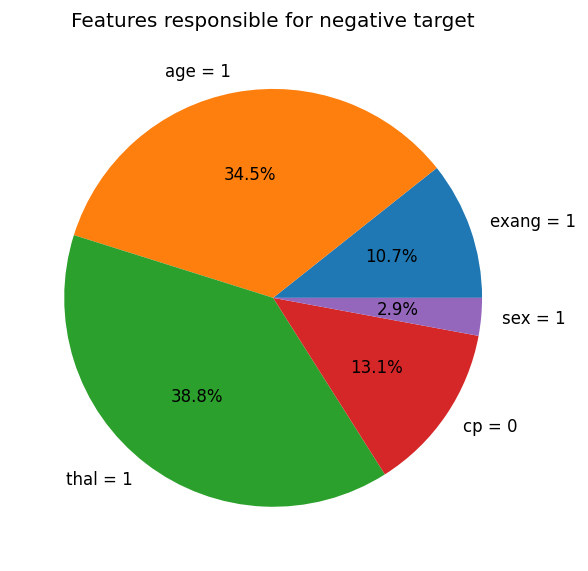

In [19]:
counter = Counter(onlyNeg)

# limiting features to top 5 only
top = 5
features_neg = list(counter.keys())[:5]
values_neg = np.array(list(counter.values()))[:5]

plt.figure(figsize=(5, 5), dpi = 120)

plt.title("Features responsible for negative target")
plt.pie(values_neg, labels = features_neg, autopct='%.1f%%')
plt.tight_layout()
plt.show()

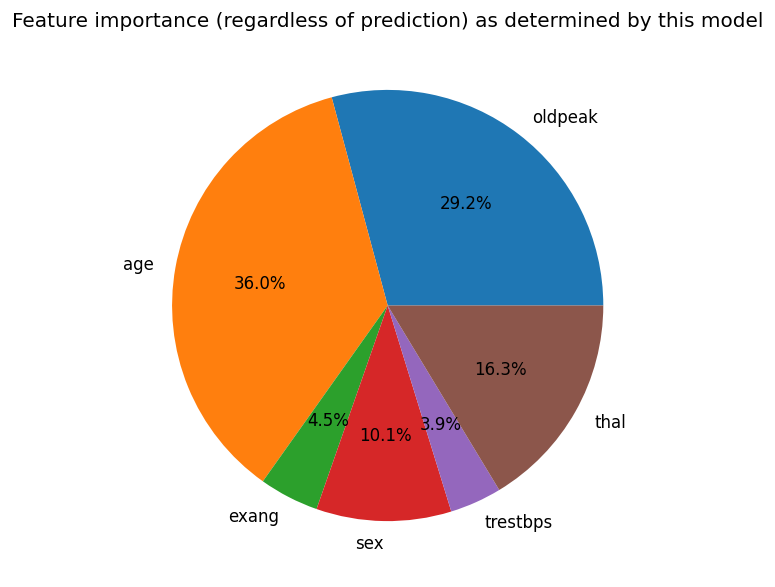

In [20]:
counter = Counter(allData)
features = list(counter.keys())
values = np.array(list(counter.values()))

plt.figure(figsize=(5, 5), dpi = 120)

plt.title("Feature importance (regardless of prediction) as determined by this model")
plt.pie(values[:6], labels = features[:6], autopct='%.1f%%')
plt.tight_layout()
plt.tight_layout()
plt.show()

Now we will compare the above *feature-importance* like data with feature importance as determined by a decision tree classifier.

In [21]:
model = DecisionTreeClassifier()
model.fit(train_data, train_labels)
pred_labels = model.predict(test_data)

features_cart = headers[:-1]
values_cart = model.feature_importances_

print("CART Model predictions: ")
print("Accuracy: ", accuracy_score(true_labels, pred_labels))
print("F1 Score: ", f1_score(true_labels, pred_labels))

CART Model predictions: 
Accuracy:  0.7377049180327869
F1 Score:  0.7647058823529412


In [22]:
values_prob = []
summation = sum(values)
for value in headers[:-1]:
    if value in features:
        values_prob.append(values[features.index(value)]/summation * 100)
    else:
        values_prob.append(0)
values_cart *= 100

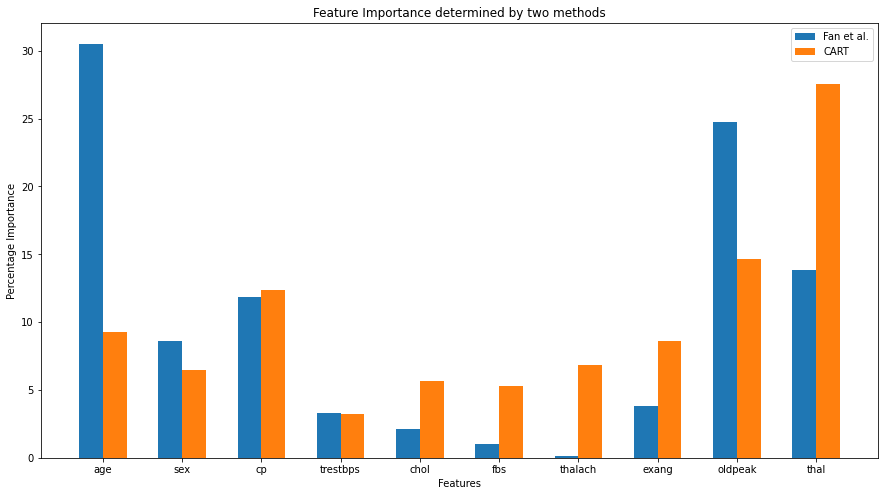

In [23]:
num_bars = len(headers) - 1
indices = np.arange(num_bars)

plt.figure(figsize = (15, 8))
width = 0.3

plt.bar(indices, values_prob, width, label = "Fan et al.")
plt.bar(indices + width, values_cart, width, label = "CART")

plt.xlabel('Features')
plt.ylabel('Percentage Importance')
plt.title('Feature Importance determined by two methods')

plt.xticks(indices + width / 2, features_cart)
plt.legend(loc = "best")
plt.show()